In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display

# to play the audio files
from IPython.display import Audio


from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from collections.abc import Iterable

from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, BatchNormalization
from keras import layers, callbacks

In [2]:
font1 = {'family':'Times New Roman','color':'blue','size':30}
font2 = {'family':'Times New Roman','color':'blue','size':20}
font3 = {'family':'Times New Roman','color':'blue','size':10}

In [15]:
Crema_path = 'C:/Users/riyas/Desktop/EMOR/Crema/'
Crema_dir_list = os.listdir(Crema_path)

In [16]:
Ex_Crema_dir_list = Crema_dir_list[:15]
Ex_Crema_dir_list

['1001_DFA_ANG_XX.wav',
 '1001_DFA_DIS_XX.wav',
 '1001_DFA_FEA_XX.wav',
 '1001_DFA_HAP_XX.wav',
 '1001_DFA_NEU_XX.wav',
 '1001_DFA_SAD_XX.wav',
 '1001_IEO_ANG_HI.wav',
 '1001_IEO_ANG_LO.wav',
 '1001_IEO_ANG_MD.wav',
 '1001_IEO_DIS_HI.wav',
 '1001_IEO_DIS_LO.wav',
 '1001_IEO_DIS_MD.wav',
 '1001_IEO_FEA_HI.wav',
 '1001_IEO_FEA_LO.wav',
 '1001_IEO_FEA_MD.wav']

In [17]:
Crema_path

'C:/Users/riyas/Desktop/EMOR/Crema/'

In [18]:
paths_crema = []
paths_crema.append(Crema_path + '1080_IEO_ANG_LO.wav')
paths_crema

['C:/Users/riyas/Desktop/EMOR/Crema/1080_IEO_ANG_LO.wav']

In [19]:
emotions_crema = []
paths_crema = []

for it in Crema_dir_list:
    # storing file paths
    paths_crema.append(Crema_path + it)
    # storing file emotions
    part = it.split('_')
    if part[2] == 'SAD':
        emotions_crema.append('sad')
    elif part[2] == 'ANG':
        emotions_crema.append('angry')
    elif part[2] == 'DIS':
        emotions_crema.append('disgust')
    elif part[2] == 'FEA':
        emotions_crema.append('fear')
    elif part[2] == 'HAP':
        emotions_crema.append('happy')
    elif part[2] == 'NEU':
        emotions_crema.append('neutral')
    else:
        emotions_crema.append('Unknown')

# dataframe for emotion of files
emotions_crema_df = pd.DataFrame(emotions_crema, columns=['Emotions'])

# dataframe for path of files.
path_crema_df = pd.DataFrame(paths_crema, columns=['Path'])
Crema_df = pd.concat([emotions_crema_df, path_crema_df], axis=1)
print(Crema_df.shape)
Crema_df.head().style.set_properties(**{'background-color': '#9490ff',
                           'color': 'black',
                           'border-color': 'black'})


(7442, 2)


,Emotions,Path
0,angry,C:/Users/riyas/Desktop/EMOR/Crema/1001_DFA_ANG_XX.wav
1,disgust,C:/Users/riyas/Desktop/EMOR/Crema/1001_DFA_DIS_XX.wav
2,fear,C:/Users/riyas/Desktop/EMOR/Crema/1001_DFA_FEA_XX.wav
3,happy,C:/Users/riyas/Desktop/EMOR/Crema/1001_DFA_HAP_XX.wav
4,neutral,C:/Users/riyas/Desktop/EMOR/Crema/1001_DFA_NEU_XX.wav


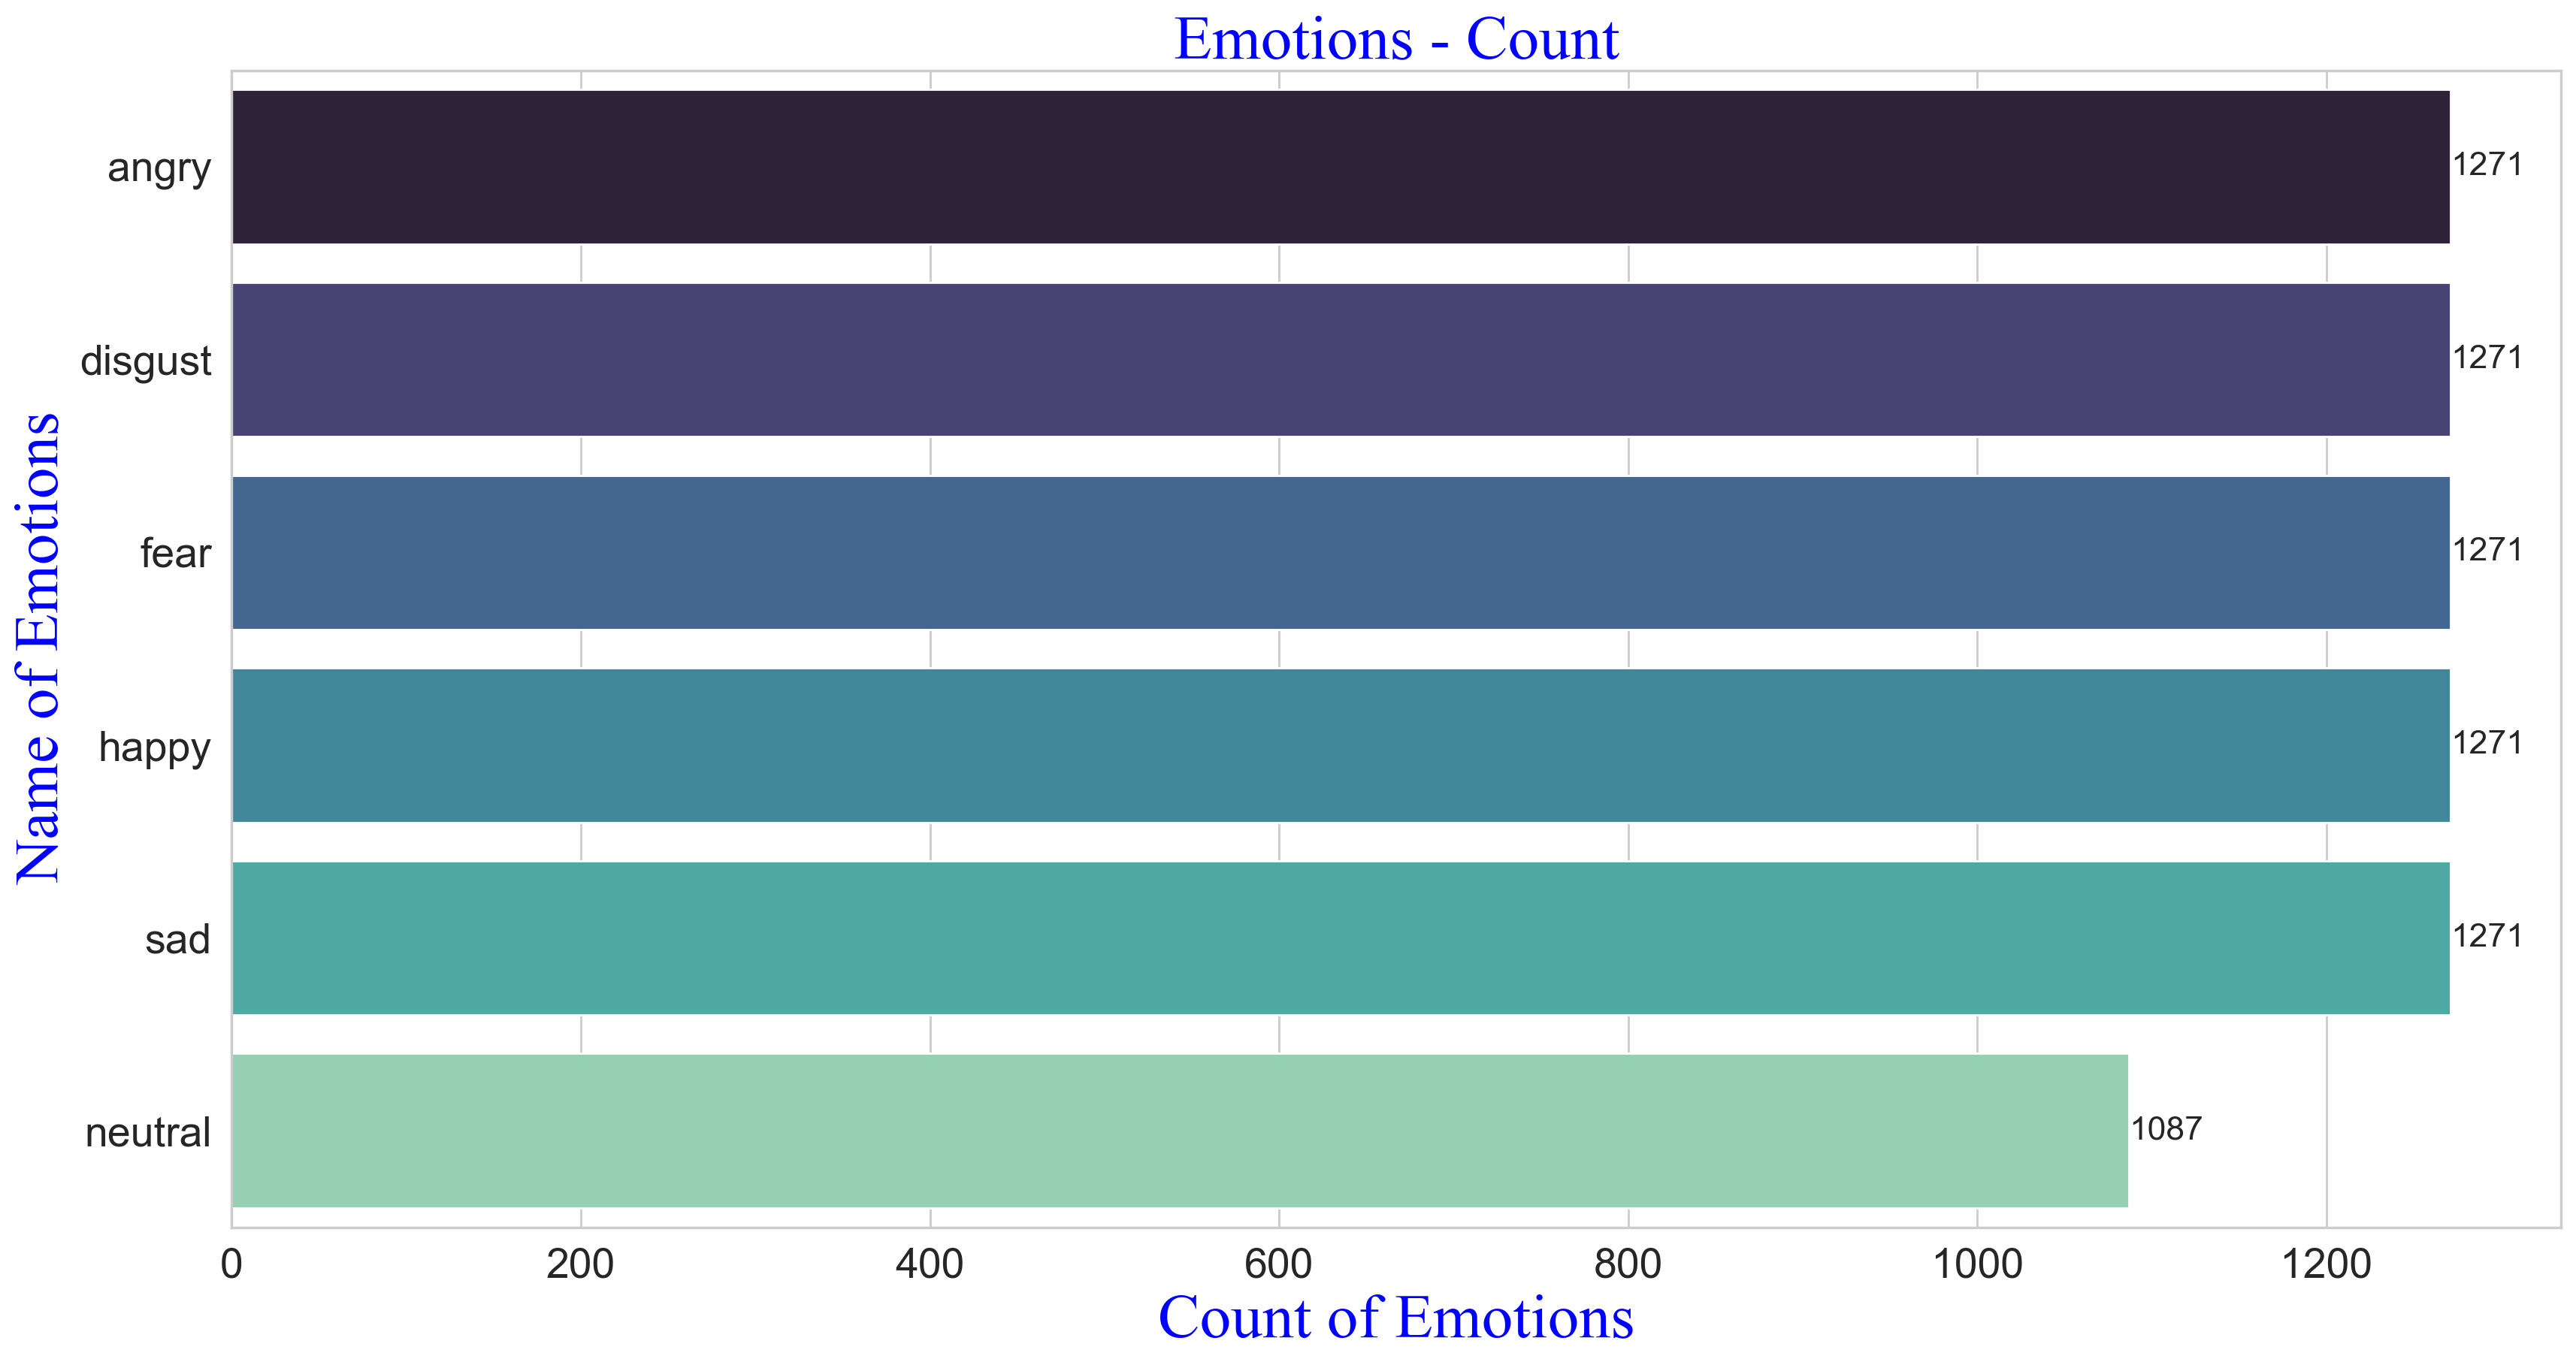

In [20]:
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,10),dpi=200)
Count_emotion = Crema_df['Emotions'].value_counts()[:]
ax = sns.barplot(x= Count_emotion, y= Count_emotion.index, palette="mako")
ax.bar_label(ax.containers[0],fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Name of Emotions", fontdict= font1)
plt.xlabel("Count of Emotions", fontdict= font1)
plt.title("Emotions - Count", fontdict= font1)
plt.show()

In [21]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration = 3, offset = 0.5) # loading of files
    mfcc = np.mean(librosa.feature.mfcc(y = y, sr = sr, n_mfcc = 40).T, axis = 0) # mfcc extraction
    return mfcc

In [22]:
extract_mfcc(Crema_df['Path'][0])

array([-3.2420966e+02,  1.2839470e+02, -1.9360773e+01,  4.5353882e+01,
       -7.7810607e+00,  1.6801313e+01, -2.5136724e+01, -2.0426500e+00,
       -1.2736441e+01, -6.0262311e-01, -1.2893606e+01, -1.9871272e+00,
       -2.5880754e+00, -1.6210602e+01,  1.1422585e+01, -1.4656595e+01,
       -4.7940116e+00, -4.4950323e+00, -2.2649436e-01, -1.0050797e+01,
       -6.2041969e+00, -4.9112763e+00, -8.6487637e+00, -1.6191193e+00,
       -5.5614214e+00,  3.7206147e+00, -6.3599520e+00,  1.2718616e-01,
       -3.5127897e+00, -1.8107889e+00, -1.8642120e+00, -2.1195211e+00,
       -1.8940720e-01, -4.1996927e+00, -3.3023129e+00, -7.4549875e+00,
       -2.4175286e+00, -5.8262515e+00, -1.8155658e+00, -3.8114743e+00],
      dtype=float32)

In [23]:
%%time
X_mfcc = Crema_df['Path'].apply(lambda x: extract_mfcc(x))

CPU times: total: 47.2 s
Wall time: 3min 37s


In [24]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(7442, 40)

In [25]:
## input split
X = np.expand_dims(X, -1)
X.shape

(7442, 40, 1)

In [26]:
enc = OneHotEncoder()
y = enc.fit_transform(Crema_df[['Emotions']])

In [27]:
y = y.toarray()

In [28]:
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
print(Iterable)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 3

In [33]:
checkpoint_filepath = 'best_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1)


def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler_callback = LearningRateScheduler(scheduler)

history = model.fit(X, y, validation_split=0.2, epochs=20, batch_size=64, callbacks=[model_checkpoint_callback, lr_scheduler_callback]  )

Epoch 1/20
93/94 [============================>.] - ETA: 0s - loss: 1.4636 - accuracy: 0.3955
Epoch 1: val_accuracy improved from -inf to 0.32169, saving model to best_model.keras
94/94 [==============================] - 13s 139ms/step - loss: 1.4634 - accuracy: 0.3956 - val_loss: 1.5861 - val_accuracy: 0.3217 - lr: 0.0010
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 1.4242 - accuracy: 0.4132
Epoch 2: val_accuracy did not improve from 0.32169
94/94 [==============================] - 19s 200ms/step - loss: 1.4242 - accuracy: 0.4132 - val_loss: 1.8068 - val_accuracy: 0.2921 - lr: 0.0010
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 1.4495 - accuracy: 0.3981
Epoch 3: val_accuracy improved from 0.32169 to 0.36669, saving model to best_model.keras
94/94 [==============================] - 19s 197ms/step - loss: 1.4495 - accuracy: 0.3981 - val_loss: 1.5443 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 4/20
94/94 [==============================] - ETA: 

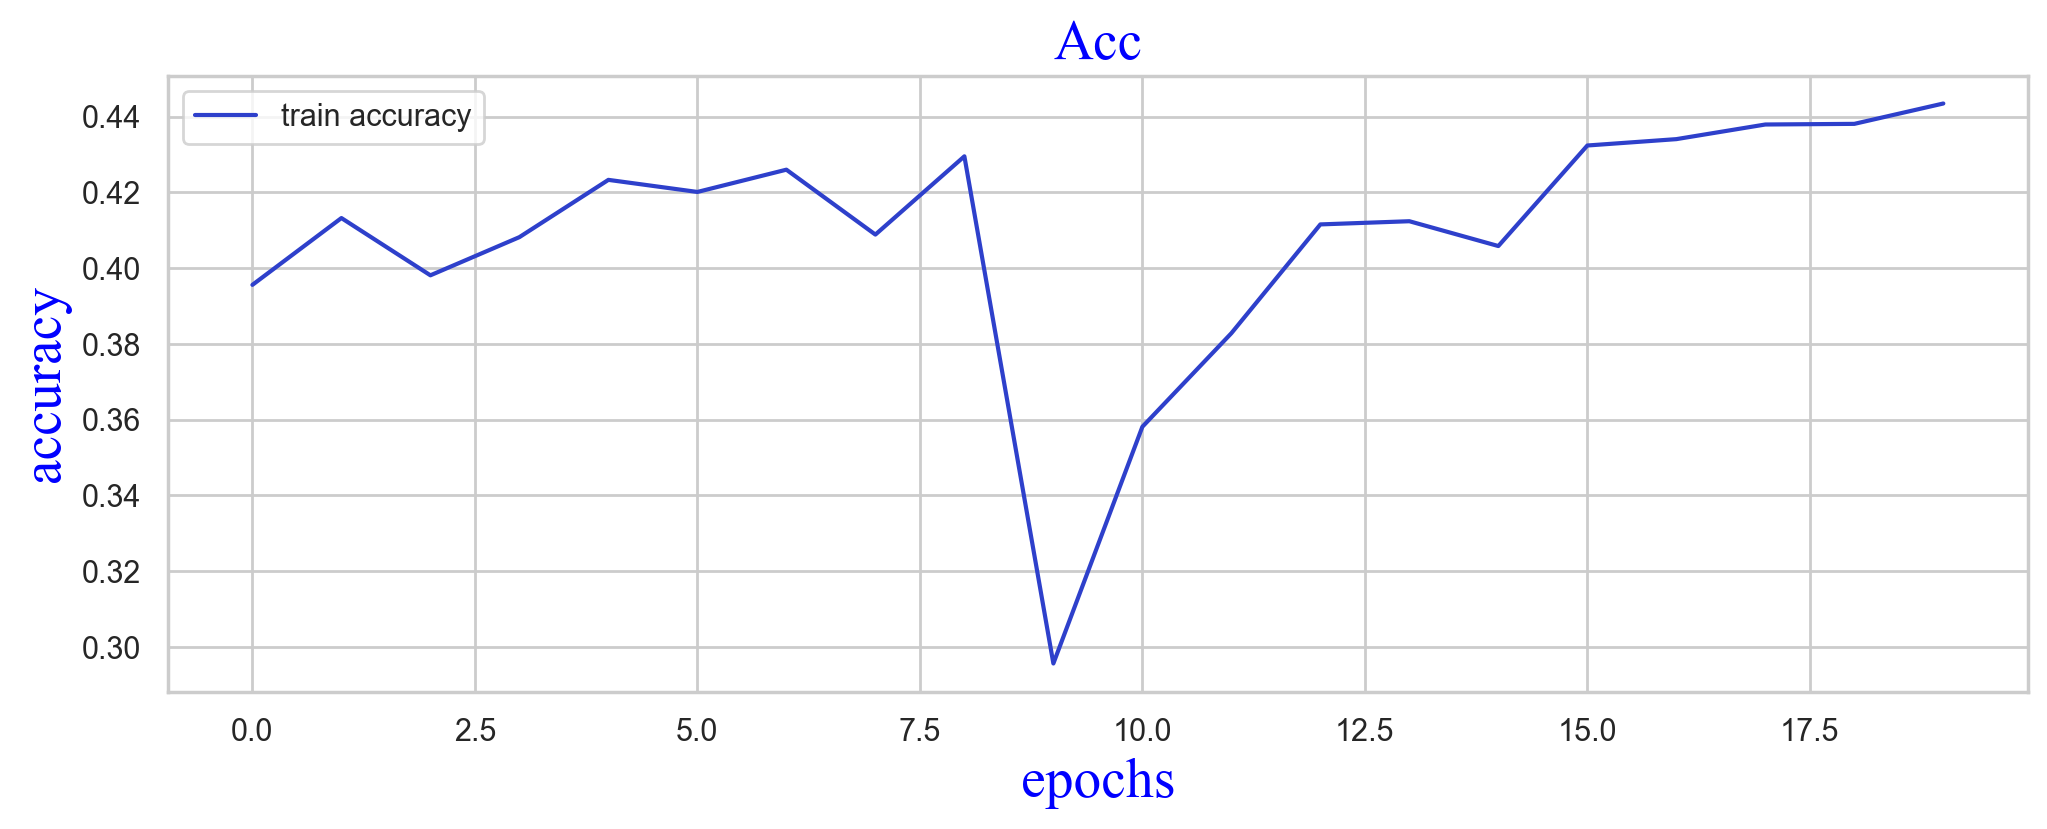

In [34]:
epochs = list(range(20))
acc = history.history['accuracy']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(epochs, acc, label='train accuracy', color='#2E40CB')
plt.xlabel('epochs', fontdict= font2)
plt.ylabel('accuracy', fontdict= font2)
plt.title('Acc', fontdict= font2)
plt.legend()
plt.show()

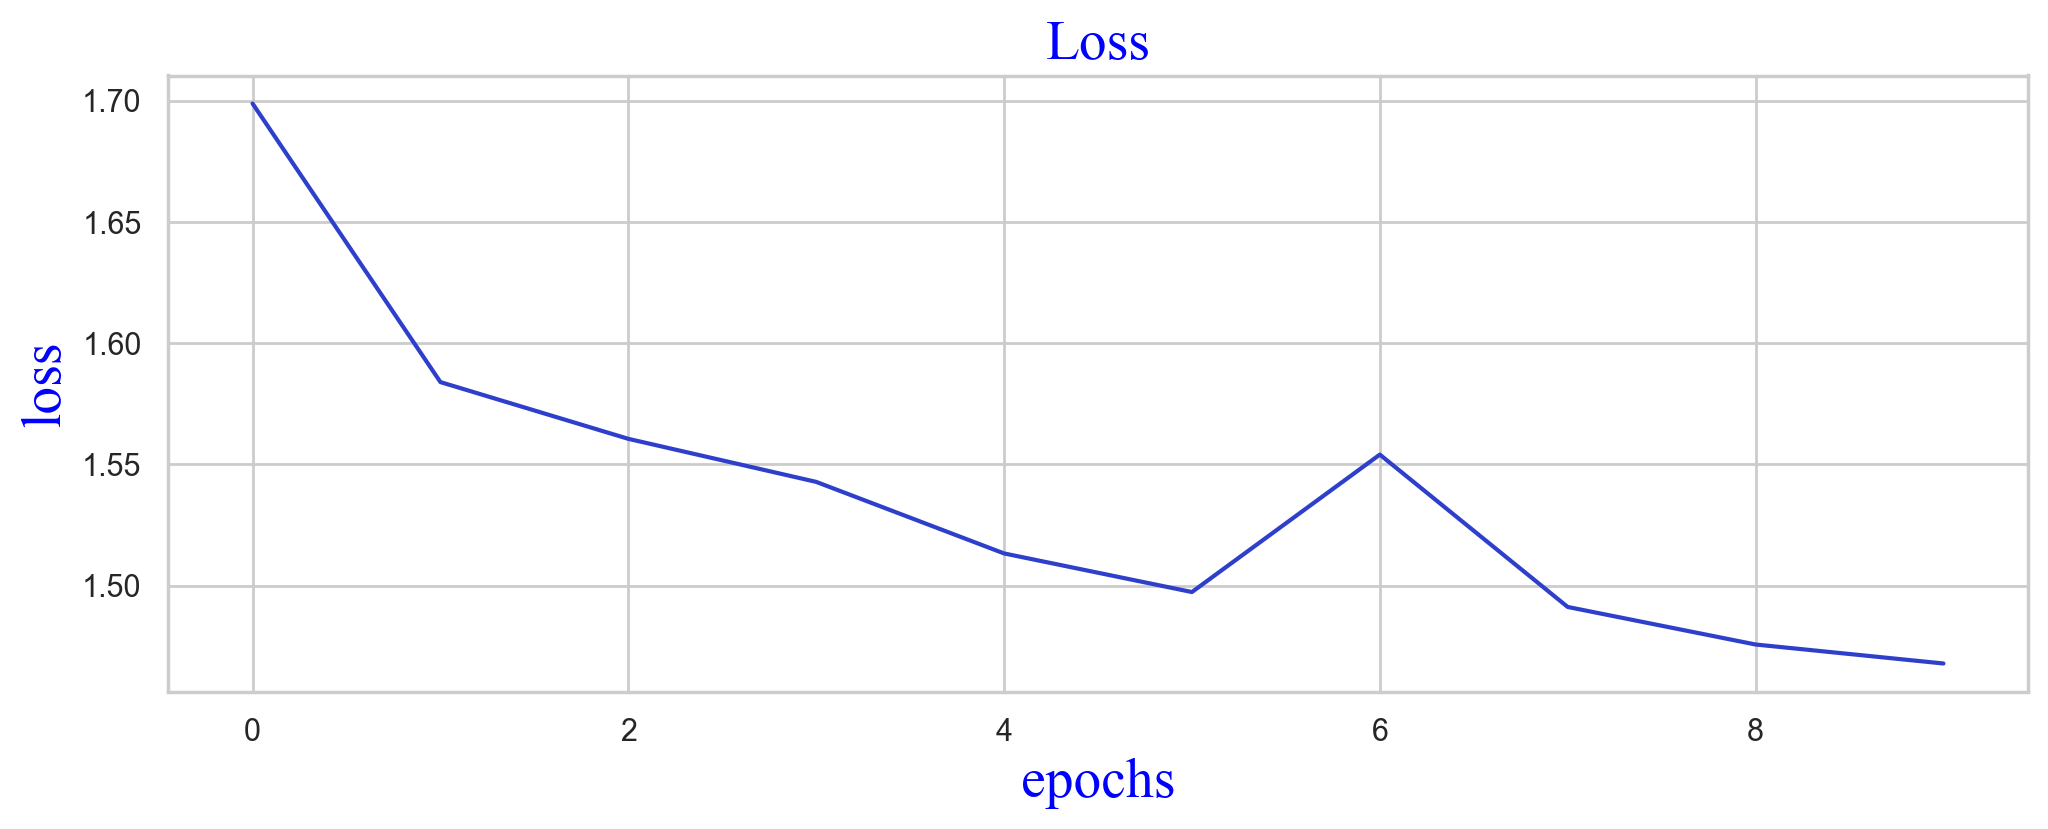

In [31]:
loss = history.history['loss']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(epochs, loss, label='train loss', color='#2E40CB')
plt.xlabel('epochs', fontdict= font2)
plt.ylabel('loss', fontdict= font2)
plt.title('Loss', fontdict= font2)
plt.show()

In [32]:
pwd

'c:\\Users\\riyas\\speech_emotions_detector\\notebooks'